In [1]:
%reload_ext autoreload
%autoreload 2
import notebooks_utils.data_notebooks_utils.general_data_notebooks_utils as gdnu
import importlib; importlib.reload(gdnu) 

<module 'notebooks_utils.data_notebooks_utils.general_data_notebooks_utils' from '/Users/dorfuchs/Documents/Projects/main_project/over-intra-news/src/notebooks_utils/data_notebooks_utils/general_data_notebooks_utils.py'>

# 1 Corpus exploration, cleaning, and LDA-ready news dataset

## 1.1 Background and motivation

The news parser pipeline ingests CC-NEWS WARC samples from S3 and produces a
`parsed_news_articles` warehouse table keyed by `(article_id, trading_day, session)`.
For each WARC response, the parser applies a sequence of strict gates:

- HTTP status must be `200` and `Content-Type` must contain `text/html`.
- The HTML payload is decoded into Unicode, reduced to visible ASCII text, and
  required to have at least 25 tokens and at most `MAXIMUM_ALLOWED_TOKENS`.
- Language detection via `langdetect.detect_langs` must identify English as the
  top language with probability at least `LANGUAGE_ACCEPTANCE_PROBABILITY`.
- Canonicalized article tokens must match between 1 and 3 firms in the S&P 500
  universe, using high-precision name-part matching rules.

Records that pass all gates are normalized into uppercase ASCII article bodies
and written downstream as `ArticleData` objects, together with firm CIKs, word
counts, and a scalar `language_confidence` score. These are then materialized
into the `parsed_news_articles` table via the loader utilities.

This design intentionally favors precision at the parser stage, but it still
admits several classes of noise that matter for topic modeling:

- Paywalls, “out-of-free-articles” stubs, and subscription gates that
  technically look like English HTML pages.
- Boilerplate investor-relations or syndicated press-release footers attached to
  otherwise valid articles.
- Navigation fragments, social-media widgets, and other CMS chrome that leak
  into the extracted body text.
- Non-english articles that passed the lang_detect gate (as lang_detect is stochastic).

To construct an LDA-ready corpus, the notebook adds a second layer of
post-parsing filters on top of `parsed_news_articles`:

1. **Strong English filter.**  
    only articles with `language_confidence` at least
   `STRONG_ENGLISH_CONFIDENCE_THRESHOLD = 0.999996` are retained. This tight cutoff
   is based on manual inspection of near-threshold articles: even at 0.999994
   occasional Spanish articles slipped through, so a more
   conservative threshold is justified.

2. **Boilerplate prefix filter (`NOISY_PREFIXES`).**  
   Articles whose `full_text` begins with known non-article prefixes are dropped
   entirely. These prefixes include:
   - Ticker/price tables and delayed-quote grids.
   - Subscription walls and “please log in / subscribe to continue reading”
     stubs.
   - Email-capture prompts and standalone disclaimers.
   - Captcha/error pages and “404 not found” responses that survive the HTML
     gate.

3. **Noisy substring filter (`NOISY_SUBSTRINGS`).**  
   Articles containing characteristic boilerplate substrings are removed, e.g.:
   - Inline “ADVERTISEMENT” blocks and sponsored-content labels.
   - “READ MORE / RELATED ARTICLES” link farms injected mid-article.
   - Syndication and wire-service boilerplate such as
     “THIS STORY WAS GENERATED BY AUTOMATED INSIGHTS” or
     “DISTRIBUTED BY PUBLIC, UNEDITED”.
   - Copyright blocks and “ALL RIGHTS RESERVED” footers.
   - Social-media widgets such as “SHARE THIS ARTICLE” or “FOLLOW US ON …”.

These post-parser gates are deliberately conservative: they are designed to
sacrifice recall in exchange for a high-precision core corpus that looks like
genuine firm-specific news when inspected manually. The resulting article ID set
serves as the **baseline training corpus for the first LDA iteration**.

Subsequent sections of the notebook:

- materialize this filtered article set back into a DataFrame via SQL;
- apply standard NLP pre-processing (tokenization, stop-word removal, vocabulary
  construction); and
- Ingest the processed data into a table to be ready for LDA modeling.

If diagnostics suggest unstable or noisy topics, subsequent iterations will be performed.
These will tighten noise patterns or add additional gates, but this notebook defines the
first rigorously filtered, LDA-ready news dataset derived from the CC-NEWS
pipeline.


In [2]:
import datetime as dt
from infra.logging.infra_logger import InfraLogger, initialize_logger
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import sample_corpus_per_day
start_date = dt.date(2016, 8, 1)
end_date = dt.date(2025, 8, 1)
logger: InfraLogger = initialize_logger("corpus_exploration_and_cleaning_utils_sample_corpus_per_day", "INFO")
sample_id_set = sample_corpus_per_day(start_date, end_date, logger) # For logging to appear change the log level to DEBUG

### 1.2 Temporal coverage of filtered articles and CIKs

Before constructing an LDA design matrix, the temporal coverage of the cleaned news
corpus is examined over the full sampling window from 2016-08-01 through 2025-08-01.
All diagnostics in this section are based on the **filtered article set** obtained from
`parsed_news_articles` after applying:

- the parser-level gates described in Section 1.1 (HTTP status, HTML decoding,
  length, language, and firm-match filters), and
- the post-parser strong-English and boilerplate filters
  (`STRONG_ENGLISH_CONFIDENCE_THRESHOLD`, `NOISY_PREFIXES`, `NOISY_SUBSTRINGS`).

The first set of plots reports the **number of retained articles per trading day**,
separately for the overnight and intraday sessions and then for both sessions combined.
These time series provide a visual check that:

- coverage is non-degenerate across the sample (no long stretches with zero articles),
- major shifts in CC-NEWS availability or parser behavior are detectable as level
  shifts, and
- the relative density of overnight vs. intraday news is understood before
  constructing session-specific signals.

The second set of plots summarizes **firm-level news support**. Using the CIK lists
attached to each article, the diagnostics report, for each CIK:

- the total number of articles mentioning the firm;
- the number of unique trading days with at least one article;
- the number of unique months with at least one article; and
- the number of unique years with at least one article.

These histograms quantify how evenly the cleaned corpus is distributed across firms
and over time. In particular, they highlight sparsely covered CIKs whose topic
exposures would be poorly estimated, and they inform later decisions about restricting
the tradable universe or imposing minimum-coverage thresholds prior to LDA training
and return-prediction regressions.

In [3]:
import pandas as pd
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import connect_with_sqlalchemy
article_sample_query: str = """
    SELECT *
    FROM parsed_news_articles
    WHERE article_id = ANY(%(samples)s)
"""
engine = connect_with_sqlalchemy()
filtered_sample_df: pd.DataFrame = pd.read_sql(
    article_sample_query,
    engine,
    params={"samples": list(sample_id_set)},
).drop_duplicates(subset=["full_text"])

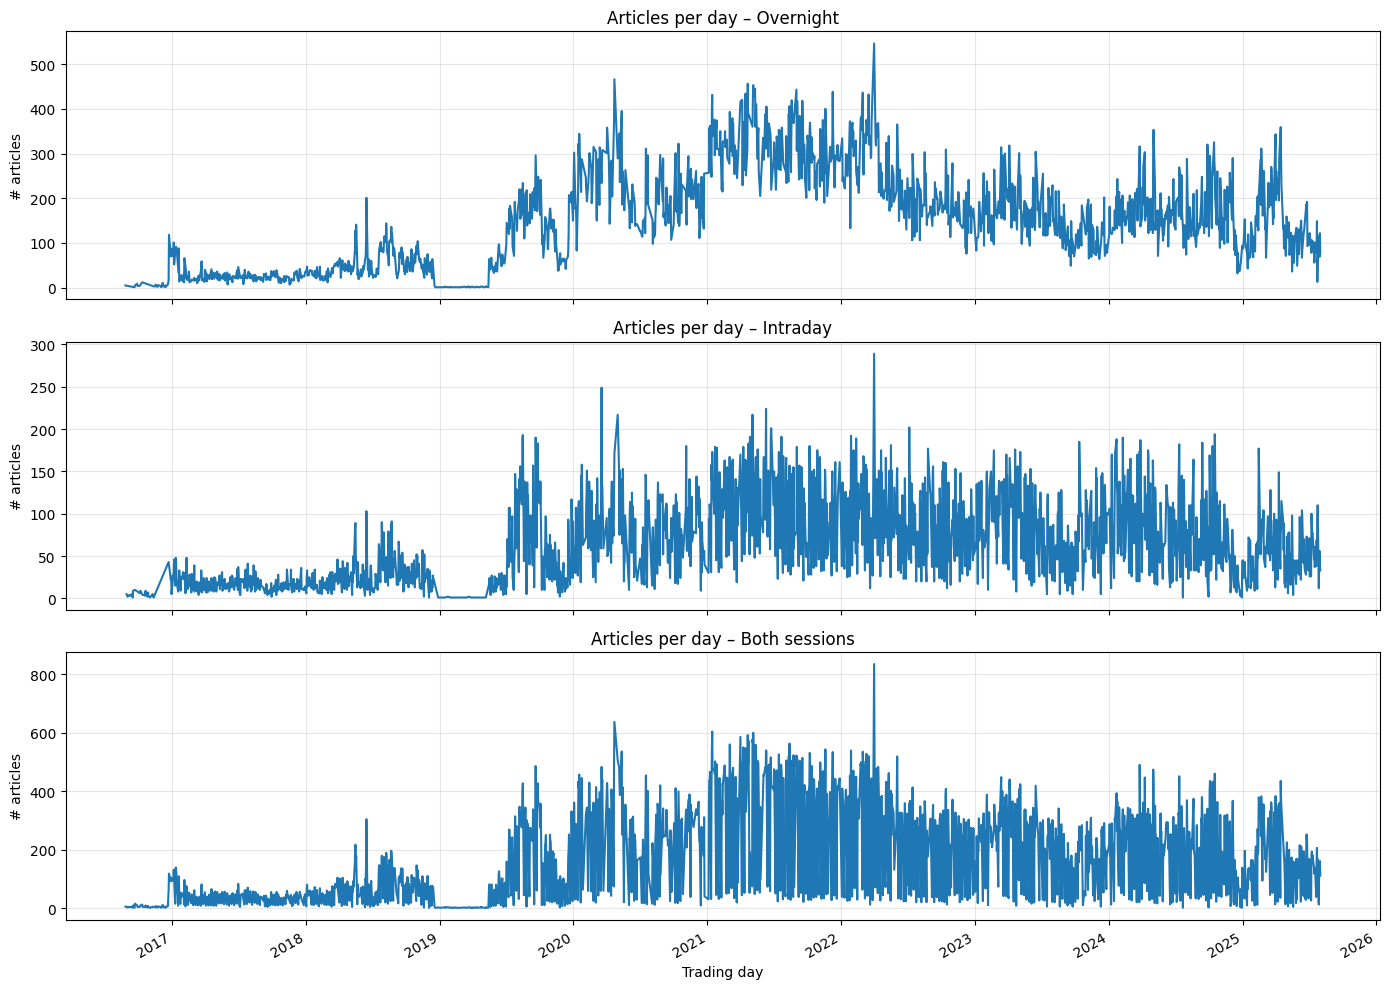

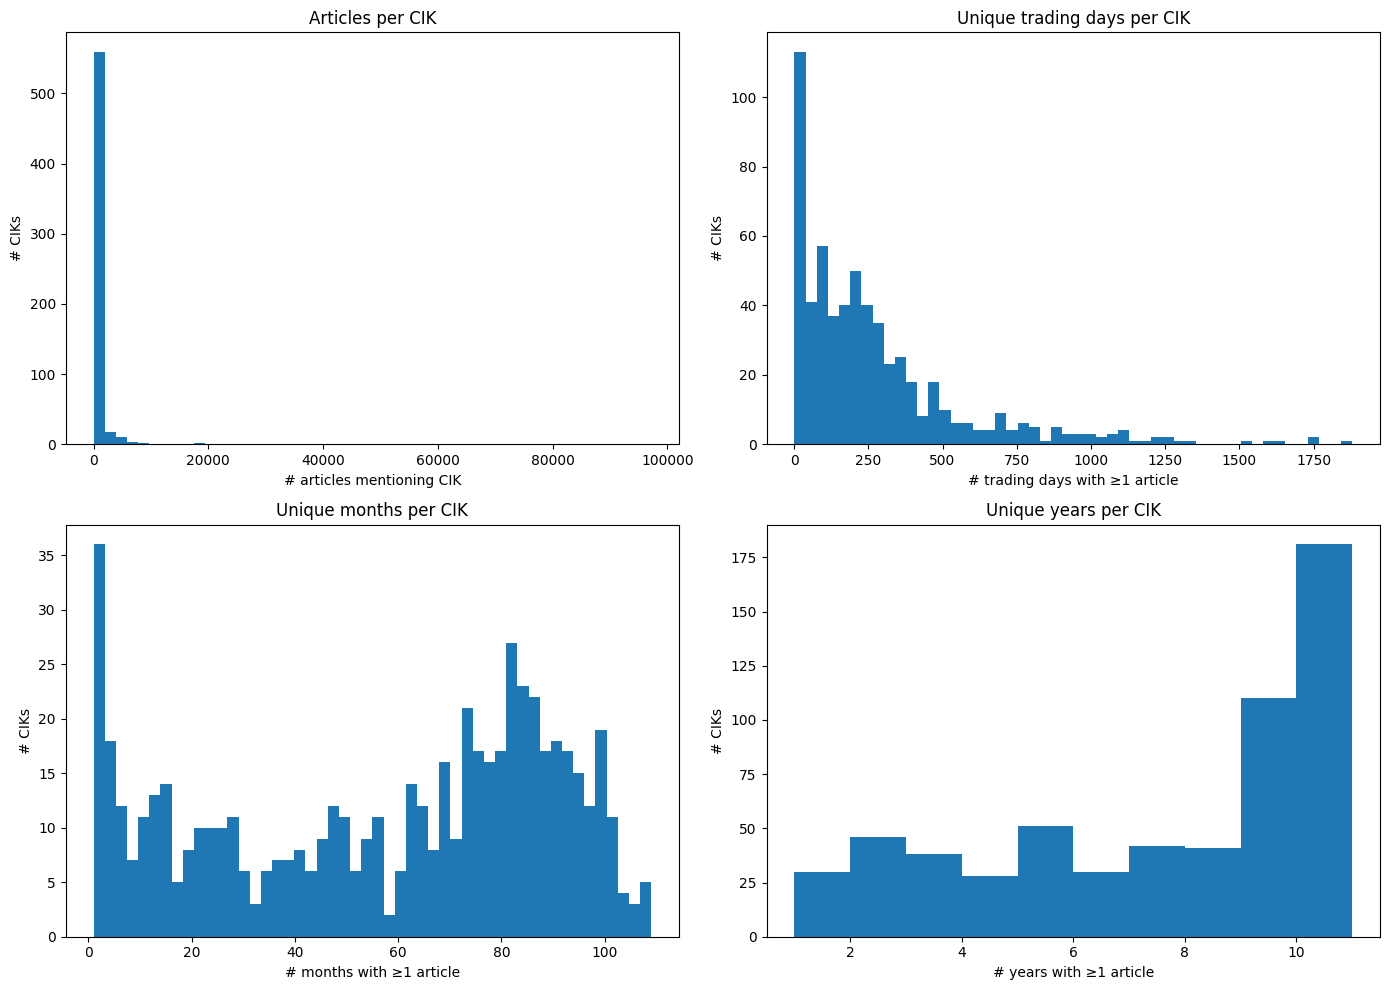

In [4]:
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import plot_article_temporal_and_cik_coverage
plot_article_temporal_and_cik_coverage(filtered_sample_df)

## 1.3 Interim assessment of coverage and implications for LDA

### 1.3.1 Article-level coverage

The article-per-day plots indicate that, after the parser and post-parser
filters are applied, news coverage is reasonably dense over the full sample and
particularly stable from 2020 onward. Overnight and intraday sessions each
exhibit on the order of a few hundred retained articles per trading day, with:

- no extended runs of zero coverage;  
- only a small number of visible level shifts; and  
- broadly stable behavior in the 2020–2025 subperiod.

This pattern suggests that, at least in the later years, both sessions provide a
sufficiently rich stream of firm-specific news for topic modeling and
return-prediction work.

### 1.3.2 Firm-level coverage

The firm-level histograms reveal a more heterogeneous picture. A non-trivial
set of CIKs is only lightly covered, but:

- most firms have at least one filtered article over the sample;  
- most firms have at least one year with a retained article; and  
- a sizable subset of firms has dozens of months and hundreds of trading days
  with coverage.

The month and year distributions, in particular, indicate that many CIKs enjoy
sustained news flow throughout much of the 2016–2025 window, while a long tail
of sparsely covered firms would yield poorly estimated topic exposures.

### 1.3.3 Implications for LDA training and regressions

In light of these diagnostics, the initial LDA model will be trained on the
**full filtered corpus** from `2016-08-01` through `2025-08-01`. Early articles
are thus allowed to contribute information about the latent topic structure,
even in periods where coverage is relatively thin.

When constructing topic-exposure time series and running return regressions:

- attention will be restricted to dates and firms with **adequate news
  support**, rather than estimating exposures from a single article in an
  otherwise empty year; and  
- coverage diagnostics will be monitored for systematic instabilities,
  especially in the pre-2020 period.

If topic exposures are found to be unstable or unreliable before 2020, a second
iteration may be run in which the LDA training corpus is restricted to 2020
onward, and the resulting exposures compared against the baseline specification.

### 1.3.4 Motivation for validity-window-normalized coverage

The next subsection examines coverage **relative to each firm’s validity
window**. For every CIK, the following window-normalized coverage ratios will be
computed:

- the fraction of years in its validity window with at least one filtered
  article;  
- the fraction of months in its validity window with at least one filtered
  article; and  
- the fraction of trading days in its validity window with at least one
  filtered article.

These quantities provide a quantitative basis for defining minimum-coverage
thresholds and for selecting a tradable universe that is well supported by the
cleaned news corpus. At this stage, coverage is aggregated across sessions;
session-specific coverage can be introduced later if required by the modeling
design.

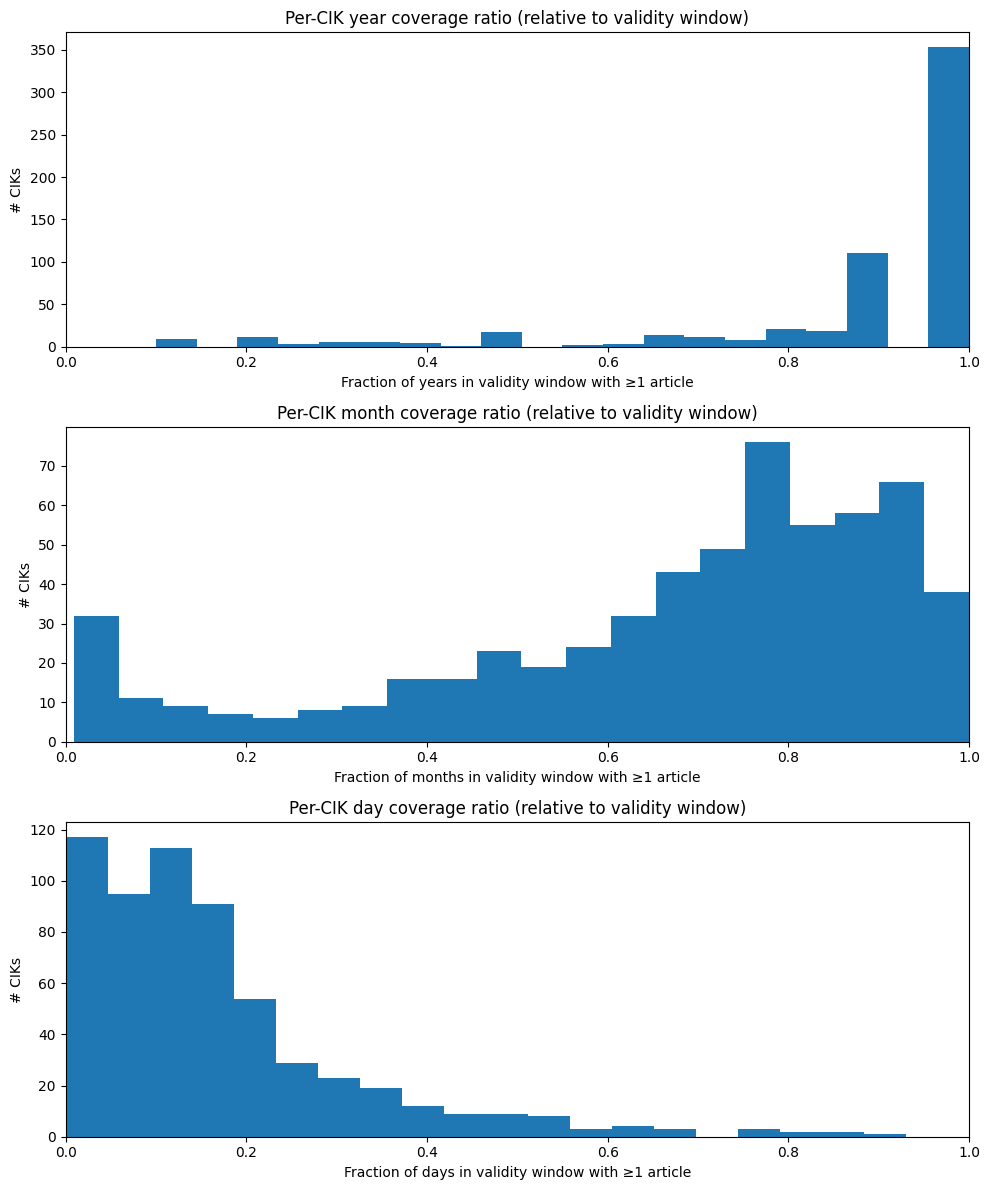

In [5]:
import sqlalchemy as sa
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import (
    compute_coverage, plot_window_normalized_coverage
)

article_sample_query: str = """
    SELECT cik, validity_window
    FROM ticker_cik_mapping
    WHERE cik = ANY(%(samples)s)
"""

engine: sa.Engine = connect_with_sqlalchemy()
cik_window_df: pd.DataFrame = pd.read_sql(
    article_sample_query,
    engine,
    params={"samples": list(filtered_sample_df['cik_list'].explode().unique())},
)
coverage_df: pd.DataFrame = compute_coverage(filtered_sample_df, cik_window_df)
plot_window_normalized_coverage(coverage_df)

### 1.4 Validity-window-normalized coverage and remaining universe

The validity-window-normalized coverage ratios translate the raw article counts into
fractions of each firm’s active life that are actually supported by filtered news. For
every CIK with at least one retained article, coverage is measured as the fraction of:

- years in its validity window that contain at least one filtered article;
- months in its validity window that contain at least one filtered article; and  
- trading days in its validity window that contain at least one filtered article.

Across the 597 CIKs with at least one article in their validity window and the
363,280 retained articles in the corpus, the resulting histograms indicate:

- **Year-level coverage.** More than 350 firms have a year-coverage ratio of 1.0,
  meaning that every year in their validity window contains at least one filtered
  article. Only a relatively small subset of firms has materially lower year-level
  coverage, so for a large portion of the universe topic exposures can be treated as
  being supported throughout the full episode.

- **Month-level coverage.** The month-coverage histogram is strongly right-skewed.
  A large majority of firms have at least half of their months covered by news
  (coverage ratio ≥ 0.5), and many firms sit near the upper tail with coverage
  ratios close to 1.0. This suggests that, conditional on being in the tradable
  universe, most firms exhibit sustained, month-to-month news flow.

- **Day-level coverage.** Day-coverage ratios are considerably sparser. For most
  firms, fewer than one fifth of the trading days in their validity window have a
  filtered article attached. Daily topic exposures will therefore be noisy unless
  some temporal smoothing or pooling is applied, especially for firms with thin
  coverage.

In line with the design choices outlined in Sections 1.2 and 1.3, the first LDA
iteration will include all 597 CIKs that have at least one filtered article within
their validity window, allowing every such firm to contribute to the estimation of
the latent topic structure. When constructing topic-exposure time series and
return-prediction regressions, firms and periods whose exposures appear unstable
or structurally under-supported can then be dropped or down-weighted based on
these coverage ratios.

The next section turns to the NLP processing required to convert the 363,280
filtered article bodies into an LDA-ready corpus: tokenization, normalization,
stop-word, vocabulary construction, and the creation of a
sparse document–term representation suitable for topic modeling.

363280